In [ ]:
#resources 
#https://towardsdatascience.com/building-an-image-color-analyzer-using-python-12de6b0acf74


In [1]:
from collections import Counter
from sklearn.cluster import KMeans
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import cv2
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service

from time import sleep
import json

/opt/anaconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [9]:
def rgb_to_hex(rgb_color):
    hex_color = "#"
    for i in rgb_color:
        i = int(i)
        hex_color += ("{:02x}".format(i))
    return hex_color

def prep_image(raw_img):
    modified_img = cv2.resize(raw_img, (900, 600), interpolation = cv2.INTER_AREA)
    modified_img = modified_img.reshape(modified_img.shape[0]*modified_img.shape[1], 3)
    return modified_img

def color_analysis(img, url):
    
    clf = KMeans(n_clusters = 5)
    color_labels = clf.fit_predict(img)
    center_colors = clf.cluster_centers_    
    counts = Counter(color_labels)
    ordered_colors = [center_colors[i].round(3).tolist() for i in counts.keys()]
    hex_colors = [rgb_to_hex(ordered_colors[i]) for i in counts.keys()]    
    plt.figure(figsize = (12, 8))
    plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    plt.title('color proportions from {u}'.format(u=url))
    plt.savefig('./plots/pie-' + url.replace('.', '-') + '.png')
    
    
    
    color_array = np.array(list(counts.values()))
    color_proportion = (color_array/sum(color_array)).round(3).tolist()
    #.tolist()
    
    color_dict = {}
    
    color_dict['centroids_rgb'] = ordered_colors
    color_dict['centroids_hex'] = hex_colors
    color_dict['color_counts'] = color_array.tolist()
    color_dict['color_proportion'] = color_proportion
    
    #print(hex_colors)
    return color_dict 

In [10]:
urls = ['www.uber.com', 'www.lyft.com', 'www.doordash.com']



====== WebDriver manager ======
Current google-chrome version is 101.0.4951
Get LATEST chromedriver version for 101.0.4951 google-chrome
Driver [/Users/amywinecoff/.wdm/drivers/chromedriver/mac64/101.0.4951.41/chromedriver] found in cache


url test foo error Message: unknown error: net::ERR_NAME_NOT_RESOLVED
  (Session info: chrome=101.0.4951.54)
Stacktrace:
0   chromedriver                        0x00000001037ec2c9 chromedriver + 5120713
1   chromedriver                        0x000000010377ae33 chromedriver + 4656691
2   chromedriver                        0x000000010336a158 chromedriver + 393560
3   chromedriver                        0x0000000103363e75 chromedriver + 368245
4   chromedriver                        0x000000010335581d chromedriver + 309277
5   chromedriver                        0x00000001033565cd chromedriver + 312781
6   chromedriver                        0x0000000103355a87 chromedriver + 309895
7   chromedriver                        0x0000000103354ff7 chromedriver + 307191
8   chromedriver                        0x0000000103353efa chromedriver + 302842
9   chromedriver                        0x00000001033542a2 chromedriver + 303778
10  chromedriver                        0x000000010336bc6a chromedr

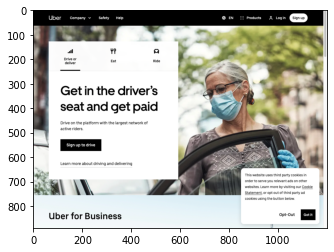

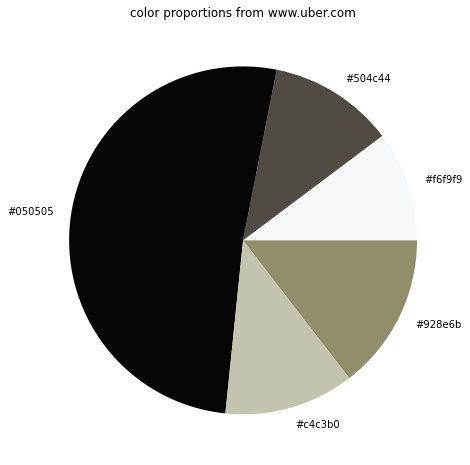

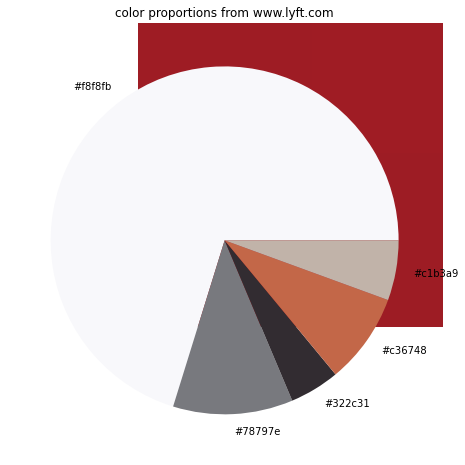

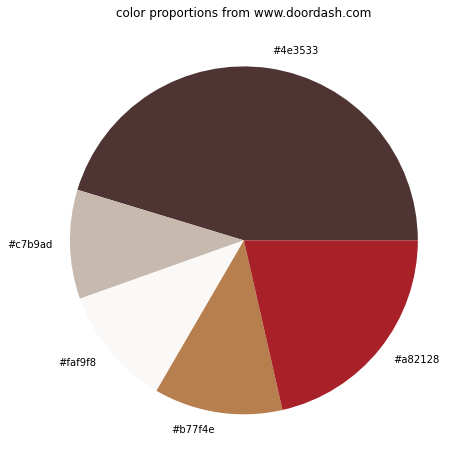

In [11]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
url_errors = {}
urls_color_dicts = []

for url in urls:
    
    try:
        
    
        driver.get('https://' + url)
        sleep(1)

        driver.get_screenshot_as_file('./site-screenshots/'+ url.replace('.', '-') + '.png')

        image = cv2.imread('./site-screenshots/'+ url.replace('.', '-') + '.png')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)

        modified_image = prep_image(image)
        color_dict = color_analysis(modified_image, url)
        color_dict['url'] = url
        color_dict['screenshot'] = url.replace('.', '-') + '.png'
        
        with open('site_screenshot_colors.json', 'a') as f:
            f.write(json.dumps(color_dict))
            f.write('\n')
                                      

        urls_color_dicts.append(color_dict)
        
        
        
                
    
    except Exception as e:
        
        print("url {url} error {e}".format(url=url, e=e))
        
        url_errors[url] = e

driver.quit()

print("end...")

In [ ]:
modified_image = prep_image(image)
color_dict = color_analysis(modified_image, url)

In [ ]:
color_dict['centroids_rgb']

In [ ]:
modified_image = prep_image(image)
color_dict = color_analysis(modified_image)
color_dict['url'] = url
color_dict['screenshot'] = url.replace('.', '-') + '.png'

In [ ]:
clf = KMeans(n_clusters = 5)
#produces a label, presumably for each pixel in the image, based on the clustering analysis
color_labels = clf.fit_predict(modified_image)
center_colors = clf.cluster_centers_ 
#counts up the total number of pixels (?) assigned to each cluster 
counts = Counter(color_labels)
#takes the r, g, and b values of the cluster centroids, and converts then in the next step to hex colors
ordered_colors = [center_colors[i].round(3).tolist() for i in counts.keys()]
hex_colors = [rgb_to_hex(ordered_colors[i]) for i in counts.keys()]    
#plt.figure(figsize = (12, 8))
#plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
#plt.savefig("color_analysis_report.png")

In [ ]:
ordered_colors

In [ ]:
hex_colors

In [ ]:
color_labels.shape

In [ ]:
color_proportion = list(counts.values())/sum(list(counts.values()))

In [ ]:
counts.keys()

In [ ]:
sum(list(counts.values()))

In [ ]:
color_array = np.array(list(counts.values()))
color_proportion = (color_array/sum(color_array)).round(3).tolist()

In [ ]:
color_proportion

In [ ]:
sum(color_array)

In [ ]:
color_array.tolist()

AttributeError: 'list' object has no attribute 'tolist'

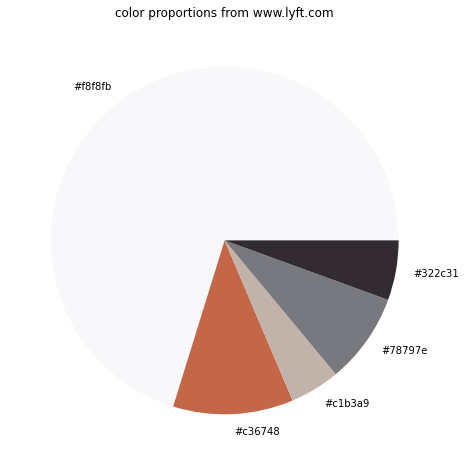

In [8]:
url='www.lyft.com'
image = cv2.imread('./site-screenshots/'+ url.replace('.', '-') + '.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
modified_image = prep_image(image)
color_dict = color_analysis(modified_image, url)


clf = KMeans(n_clusters = 5)
color_labels = clf.fit_predict(img)
center_colors = clf.cluster_centers_    
counts = Counter(color_labels)
ordered_colors = [center_colors[i].round(3).tolist() for i in counts.keys()]
hex_colors = [rgb_to_hex(ordered_colors[i]) for i in counts.keys()]    
plt.figure(figsize = (12, 8))
plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
plt.title('color proportions from {u}'.format(u=url))
plt.savefig('./plots/pie-' + url.replace('.', '-') + '.png')
    
    
    
color_array = np.array(list(counts.values()))
color_proportion = (color_array/sum(color_array)).round(3).tolist()
    #.tolist()
    
color_dict = {}
    
color_dict['centroids_rgb'] = ordered_colors
color_dict['centroids_hex'] = hex_colors
color_dict['color_counts'] = color_array.tolist()
color_dict['color_proportion'] = color_proportion.tolist()